# Goal of the project
The goal of this project is to learn a policy for an inverted pendulum model to make it do a swing-up motion. Beyond the task of inverting a pendulum, the goal is to also gain an understanding on how Q-learning works, its limitations and advantages.

To make the problem interesting, the inverted pendulum has a limit on the maximum torque it can apply, therefore it is necessary for the pendulum to do a few "back and forth" motions to be able to reach the inverted position ($\theta=\pi$) from the standing still non-inverted position ($\theta=0$). 

<img src='pendulum.png' width="120">

In the following, we will write $x = \begin{pmatrix} \theta \\ \omega \end{pmatrix}$ as the vector of states of the system. We will also work with time-discretized dynamics, and refer to $x_n$ as the state at time $t = n \Delta t$ (assuming discretization time $\Delta t$)

We want to minimize the following discounted cost function
$$\sum_{i=0}^{\infty} \alpha^i g(x_i, u_i)$$ where 
$$g(x_i, u_i) = (\theta-\pi)^2 + 0.01 \cdot \dot{\theta}_i^2 + 0.0001 \cdot u_i^2 \qquad \textrm{and} \qquad\alpha=0.99$$
This cost mostly penalizes deviations from the inverted position but also encourages small velocities and control.

## Q-learning with a table
In the first part, we will implement the Q-learning algorithm with a table. To that end, we are given a robot (defined in the package ```pendulum.py```) with a function ```get_next_state(x,u)``` that returns $x_{n+1}$ given $(x_n, u_n)$. We will assume that $u$ can take only three possible values. Note that $\theta$ can take any value in $[0,2\pi)$ and that $\omega$ can take any value between $[-6,6]$. 

In order to build the table, we will need to discretize the states. So for the learning algorithm we will use 50 discretized states for $\theta$ and 50 for $\omega$. Keep in mind that the real states of the pendulum used to generate an episode will not be discretized.


1. Write a function ```get_cost(x,u)``` that returns the current cost $g(x,u)$ as a function of the current state and control.

2. What is the dimension of the Q-table that you will need to implement (as a numpy array)? Why?

3. How can you compute the optimal policy from the Q-table? And the optimal value function? Write a function ```get_policy_and_value_function(q_table)``` that computes both given a Q-table as an input.

4. Write a function ```q_learning(q_table)``` that implements the tabular Q-learning algorithm (use episodes of 100 timesteps and an epsilon greedy policy with $\epsilon=0.1$). The function should get as an input an initial Q-table  and return a learned Q-table of similar size. Use the function ```get_next_state``` from the pendulum package to generate the episode (do not discretize the real state of the pendulum!). During learning store the cost per episode to track learning progress.

5. How many epsilodes (approximately) does it take for Q-learning to learn how to invert the pendulum when $u \in \{-4,0,4\}$? (use a learning rate of 0.1). Show the learning progress in a plot.

6. Using the simulate / animate functions (cf. below) how many back and forth of the pendulum are necessary to go from $x = [0,0]$ to the fully inverted position? Plot the time evolution of $\theta$ and $\omega$. 

7. Plot the found policy and value function as 2D images (cf. below).

8. Answer questions 5 to 7 when using $u \in \{-5,0,5\}$. What quantitative differences do you see between the computed policies in 5. and 8.? Can you explain?

9. How is learning affected when changing $\epsilon$ and the learning rate? Why?

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import pendulum

In [2]:
# we can get the integration step used in the simulation
print(f'dt is {pendulum.DELTA_T}')

# we can get the size of its state and control vector
print(f'number of states {pendulum.NUMBER_STATES} and number of controls {pendulum.NUMBER_CONTROLS}')
print('the states are indexed as follows: theta, omega')

# we can get the maximum velocity of the pendulum (omega)
print(f'the max velocity is {pendulum.MAX_VELOCITY} rad/seconds')

dt is 0.1
number of states 2 and number of controls 1
the states are indexed as follows: theta, omega
the max velocity is 6.0 rad/seconds


In [3]:
# the next_state function allows to compute the next state given a current state and action
# This is going to be very helpful to run an episode!

# assume we set x = [theta, omega] = [0,0] and u = 5, we can get the next state using
x = np.array([0.,0.])
u = 5
x_next = pendulum.get_next_state(x, u)

print(f'the next state is {x_next}')

the next state is [0.02227801 0.48969119]


In [8]:
test_arr = np.random.randint(100, size=(12)).reshape((2,2,3))
print(test_arr)
print(np.min(test_arr, axis=2))
print(np.argmin(test_arr, axis=2))
print(np.argmin(test_arr, axis=2).shape)
print(test_arr[0][1])
print(np.argmin(test_arr[0][1]))

[[[82 46 96]
  [ 5 93 97]]

 [[42 53 59]
  [51 60 32]]]
[[46  5]
 [42 32]]
[[1 0]
 [0 2]]
(2, 2)
[ 5 93 97]
0


In [5]:
def get_cost(x, u):
    theta = x[0]
    omega = x[1]
    
    current_state_cost = (theta - np.pi) ** 2 + 0.01 * (omega ** 2) + 0.0001 * (u ** 2)
    return 


def get_policy_and_value_function(q_table):  # dim of q_table: 50 * 50 * 3
    # Find the corresponding optimal value function and policy according to a q_table
#     num_of_theta = q_table.shape[0]
#     num_of_omega = q_table.shape[1]
#     num_of_control = q_table.shape[2]
    
#     J_optimal_value = np.zeros([num_of_theta, num_of_omega])
#     Mu_optimal_policy = np.zeros([num_of_theta, num_of_omega])
    
    J_optimal_value = np.min(q_table, axis=2)
    Mu_optimal_policy = np.argmin(q_table, axis=2)
    return J_optimal_value, Mu_optimal_policy


alpha = 0.99
learning_rate = 0.1
u_control_policy = np.array([-4,0,4])

# we don't want 2pi to be in the set because it's the same as 0
# we generate 50 equally spaced points for theta
discretized_theta = np.linspace(0, 2*np.pi, 50, endpoint=False)

# we generate 50 equally spaced points for omega
discretized_omega = np.linspace(-6, 6, 50)


def get_closet_state_and_index(x):
    theta = x[0]
    omega = x[1]
    
    index_in_discretized_theta = np.argmin(np.abs(discretized_theta - theta_arbitrary))
    index_in_discretized_omega = np.argmin(np.abs(discretized_omega - omega_arbitrary))
#     closest_theta_state = discretized_theta[index_in_discretized_theta]
#     closest_omega_state = discretized_omega[index_in_discretized_omega]
    
    return index_in_discretized_theta, index_in_discretized_omega#, closest_theta_state, closest_omega_state
    
    
def q_learning(q_table):
    epochs = 100  # number of epochs
    epsilon = 0.1  # probability to explore random action
    
    updated_q_table = np.zeros(q_table)
    for _ in range(epochs):
        number_of_timesteps = 100  #  number of time step each episode
        current_state = np.zeros(2,)  #  initial state
        for i in range(number_of_timesteps):
            policy_explore_prob = np.random.rand()
            control_forces = 0
            
            closet_index_0, closet_index_1 = get_closet_state_and_index(current_state)
            J, Mu = get_policy_and_value_function(q_table)  # optimal value function and policy of current Q table 
            if policy_explore_prob < epsilon:  # explore probability
                control_forces = np.random.randint(3)  # random policy
            else:
                control_forces = Mu[closet_index_0][closet_index_1]  # Optimal policy - argmin Q(x,u)
                
            old_q_table_term = q_table[closet_index_0][closet_index_1][control_forces]
            current_cost = get_cost(current_state, control_forces)  # g(x,u)
            next_state = pendulum.get_next_state(current_state, control_forces)  # next_state, x_{t+1}
            next_closet_index_0, next_closet_index_1 = get_closet_state_and_index(next_state)
            
            TD_error = current_cost + alpha * J[next_closet_index_0][next_closet_index_1] - old_q_table_term
            updated_q_table[closet_index_0][closet_index_1][control_forces] = old_q_table_term + learning_rate * TD_error
            
            current_state = next_state
            
        q_table = updated_q_table
    
    return updated_q_table
    

In [6]:
# we can also simulate the robot but we need to provide a controller of the following form
def dummy_controller(x):
    """
        the prototype of a controller is as follows
        x is a column vector containing the state of the robot
        
        this controller needs to return a scalar
        you may want to modify this controller to use the policy table to compute control output
    """
    # here we do nothing and just return a 0 control
    return 0.




<IPython.core.display.Javascript object>


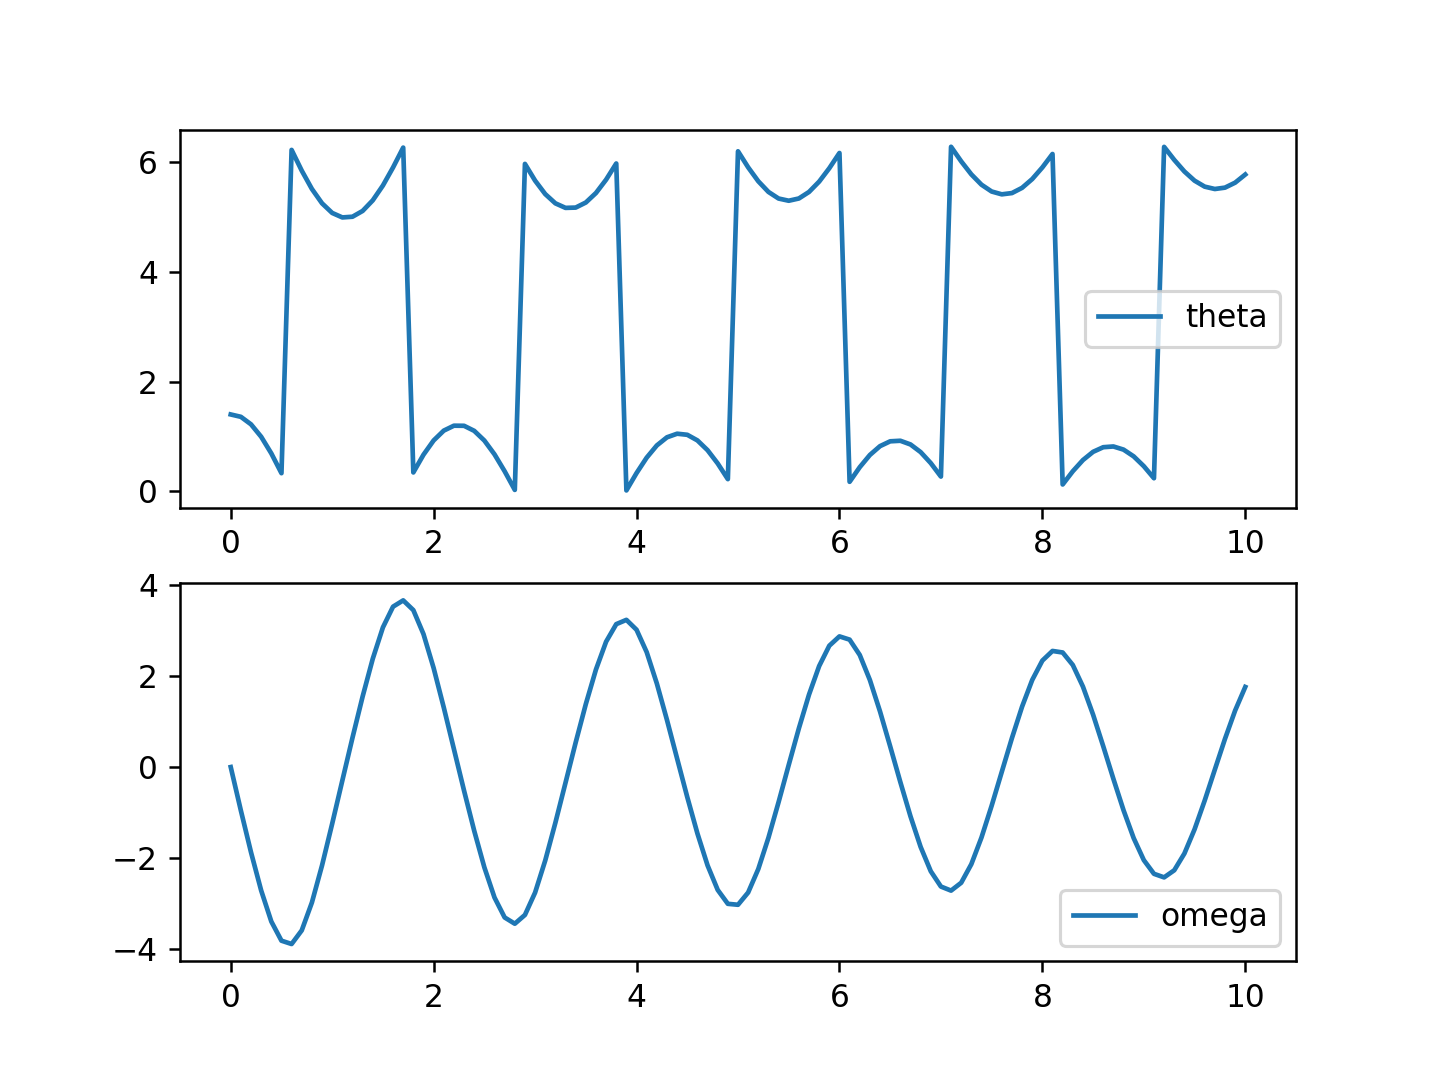

<IPython.core.display.Javascript object>


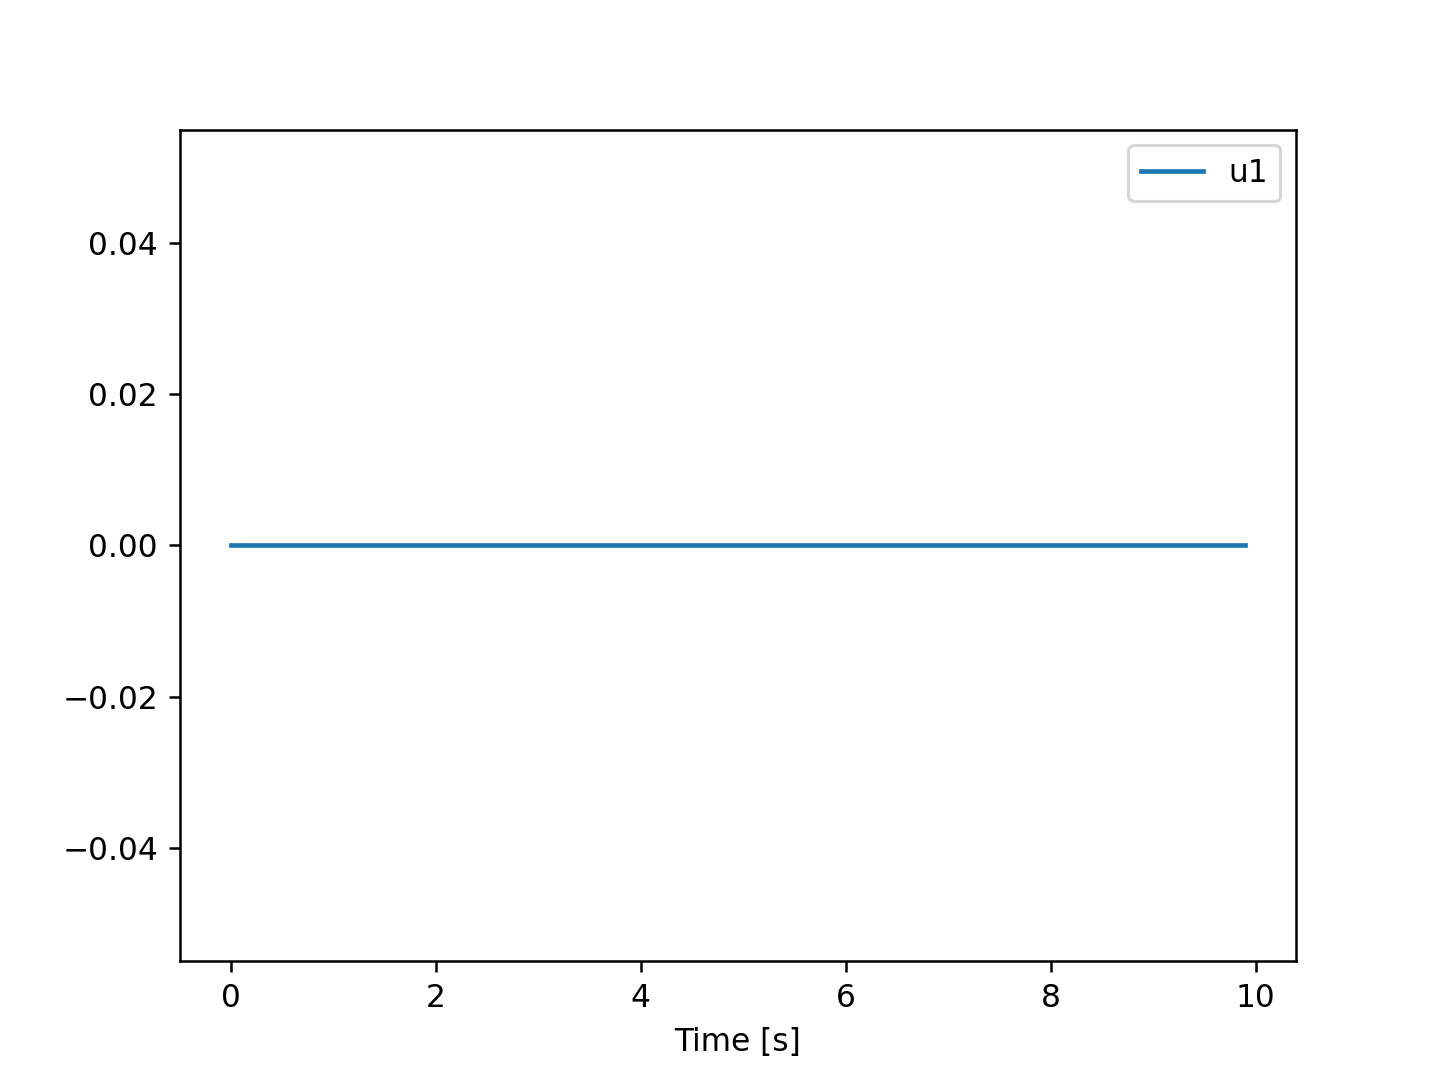

Text(0.5, 0, 'Time [s]')

In [7]:
# we can now simulate for a given number of time steps - here we do 10 seconds
T = 10.
x0 = np.array([1.4,0.])
t, x, u = pendulum.simulate(x0, dummy_controller, T)

# we can plot the results
plt.figure()

plt.subplot(2,1,1)
plt.plot(t, x[0,:])
plt.legend(['theta'])

plt.subplot(2,1,2)
plt.plot(t, x[1,:])
plt.legend(['omega'])

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1'])
plt.xlabel('Time [s]')

In [6]:
# now we can also create an animation
pendulum.animate_robot(x)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAA2I9tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwMSBiMDkzYmJlIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMiAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DqxliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCLH/2+kONwAT9lg/NYjL/FoB9aiK4jE+YrYPvM3VJY4vjNnyLGP2YlbJp/NpA8k+C6YwpDlXn2f
y1TN9QNLS2doYg16nA3KBIICjrY2PQjGG/lJWgkVRima9js6Vx5WimbQrt72ItjNL7sLxElEA17m
hCeWbA7zyXROB8c1qwBwG6mF4Z9p4RctmYdY75fZ9PIcL6+1DtNo159DsIedHWW5BeeoUeMIr15+
LI/6q7q3wu/lDZN9tIlTOzRJ5hxurCa6TP3YdJ0Pua9/TkOnB1BZtIQdZE2NNeG6ZBWKX2qe8riq
2xS9wgxfOhJNJt6YhrXMm7zjVbb5XjgbkHcxnQGuWAediwJYqi3fm4ujHJ0imNhaD37uUGnV0uhF
HwdHqWMHnkkZYv5dDA2wu6b3OQ9KRwn5X82CXdBrwTfk3PfgmQi7fk9RABc2Y/lr+wk7/NGHIW6x
bWrCQjWI3kMgmnZdCoBs9vyRLBTpCVIj7av8Cn5DSXlEn/Sd+3NrATU5DNYJFIv98ZA73iur1uVp
0nGsXxBFlJ1H2+4c5v0sc6J3GHQJ+QWfXMMMpnrGfqYO8ABZaLotsFB/LHkbFwuip7F+yFSJmOPj
nv2p6EsCzZ4ktjM8W1dXaEG2suS0/qszjbFQY02+AIr2VapQc+1BFWqrc1pu17ohfTzwXn2fKAC5
21nnAAADASwwUcqaY5AkvpzqiYbgXMusVE5UI3xjdJZl9YGeFULlnFgp1TO5S2Liv14oliSHmEgB
fyvgJUGY+viXF+3slMUUNvjN43DbvlyPftQmotTwEnNL4qk7QPWZ3SmEKQIZSahmspk1agpd4wfF
cpFQQ9gsbtwwexR4GsR+/CN/pMgE+ajlf8mz01SKnolBbcTg1BxgDJOFsSrlFqt/zmg5VvX1lfOH
athovoy7dd/vYUqjLvlvYNQWFbXVqwvSB187D1x3r/8vNSgrBvt+euGnryL6g8iPLW9lVHECSnnr
R7oYrWc9p6Ly4KNL7ZyHNp9LGfmQZvPW/9e6S2omsxVxPmRNApuDGezGU5FoQf9T1cYLTVJN6LG/
Y2SOrpwl+3HxGi2Fpy7DJzYOn2skUkK/guj2C2UDRbE0Fyb+z+044NtFbuOyj4YxO0XIPYSd4AAA
AwP8PctoNCIIEvLaoJ6ko/2auyKpLkDaA9SmwbZWB6lvKOJknWTWXdXt7bpIr+LgizsMzhuul0li
RgMs2FITDARLM/2YVciIf/37Tuf5iYy2NYXf5DSPLlLxX0CmB0aM+yX7m+FgnEGh+VybxlWsxKay
snDKMU1Oe7JJ6erXx3eWpDZ91OCybpeEqhsl9YOuC3jSL7XBGI9FlXhTOjBbywYiV/GPzF+uRkbM
NjHAJcPVqy/xK6+HVHqON0HgyIvhrsakXbfhuBp5kyr46geOOtAb30nBv1oBa9gBQUKgkt+Y7bEd
SpHA72wUIpONkSm+kwhWABoOmDpoMVwUVgb1Igt9zvf4bpgYF/sVfhzwBQtfilmYeLhhYcZC8tgW
RDQAufKOzcxNLfl5GnUXHOEDOzmndzWNSV1WFHn5Q5RbmPZfW69VAzvzYdzQ39obd+xz5paIoNdp
zc/Psd4f5Urm6OUiLWFBy4vSM4dHgAyH4Wk9bj3L0uh/IOwb6SrMltNZFMjbOdBVhK3YGGXXsAkf
HPuEp5NUa8HLEe9Q5sjjV3gQ8o6WTiJc/1g6/G18QpiyoAUs84z5vRWgYaRxsF5wfXEhTTeLQsv4
JoELYNu9POrMo8rm+5ySYpfv0vog0ykGqeFa2gB5oLhND7/XVgLqrjC2Fy/2/ta4PVXdkS4h7kSo
6kWUr8N9HzjG0SW2js+PySV2BeS3Y9p/pNZwTTIeB8BMf2Y6vOYiA7wCjZFA5U889BS6asekAoBW
k/orCHIru2SZ6xOtt7HSxUrRZ/yqJf/1pumXpIeqn2ozoqtn85s5INYN5/95uLzQU9oJSUE76HX9
CmZhjqzY48ZT/3su0d6l1zQXrUzF61rIA0eQHvpCH3u35t/PgNv0CAkOVAcTFM18eUlm20dhVl2P
1a+J2YUBPOqnRk1uVF8v4G+UMN/a7beV5bUWzsnkpW1vLlsVVEAn380syPYzzkDBR3aFpnoffbo4
6zYyBJEAdQodNSWLuxjCGHcKJY/7TfvTzHurJKptqr8TP8FeKWFAwwFBXqWwqNIivQJijy9gtNJ7
izbWB1oO2mK+gpGQ0zAGimn7Rlc0jIK9tZYdR/46ytq5W9rxOEhjGSBdTw5xlWjlAil9xM6lRALG
UEv8Jeo3dfjK/W0Pga6vlJnjKq0mVmZ5upBMSPbboP3ErxpVU8W3fXFImjYzaDSIOLXe1HgHlJEP
/GZi6Fkdd3Ec90yZ4l8sHd3vrNV478P0ckgDxKqLCvYVadHumfkfCTKnK0J12KipNyZxLcuTv5GX
2/s3tqm0Cx/Q+56OJKRukVFIG3wbZoHOjfKIvOAaf6NtZjPrg5wRGcQwkX8nFqwR/x4Pide6z1h1
UBlRJ+L1AHkfrrqTdEW8uxkoSueK6yE+YKCTwHHIIisbLGhSZwsb4vGOMQaW+mcEfGUrHyI7HuiY
4Tm+KtYWAOS84oS76bN/KKRkPesa0NYAmwxbrWRh9eWrdAirFP6ACEQnTTVKtvIuFCWi8kA+jVoC
s2IjMrao8PRx0d3ulYCZx5IcFqzgjh08tM5DxiKySZOjRrmQoP66jJ5rHSG4owDe8SGRpGf+setC
LXmJfnYSbG3Wd+6wMq3SZTjUlElArU2RnJLr4OoYM4NHjIiMai93ATXRffDA9CPL3hdueqsSyrBl
Z8Z+kSVB31xKzXv1zQMnC

We also need to discretize the state space, we discretize $\theta \in [0, 2\pi]$ in 50 states and $\dot{\theta} \in [-6, 6]$ is 50 states. For example:

In [26]:
# we don't want 2pi to be in the set because it's the same as 0
# we generate 50 equally spaced points for theta
discretized_theta = np.linspace(0, 2*np.pi, 50, endpoint=False)

# we generate 50 equally spaced points for omega
discretized_omega = np.linspace(-6, 6, 50)

# now given an arbitrary continuous state theta
theta_arbitrary = 0.2
omega_arbitrary = 0.5

# we can find the index of the closest element in the set of discretized states
index_in_discretized_theta = np.argmin(np.abs(discretized_theta - theta_arbitrary))
index_in_discretized_omega = np.argmin(np.abs(discretized_omega - omega_arbitrary))

# and find the closed discretized state
closest_theta_state = discretized_theta[index_in_discretized_theta]
closest_omega_state = discretized_omega[index_in_discretized_omega]

print(f'the discretized theta closest to {theta_arbitrary} is {closest_theta_state} with index {index_in_discretized_theta}')
print(f'the discretized omega closest to {omega_arbitrary} is {closest_omega_state} with index {index_in_discretized_omega}')

the discretized theta closest to 0.2 is 0.25132741228718347 with index 2
the discretized omega closest to 0.5 is 0.6122448979591839 with index 27


<IPython.core.display.Javascript object>


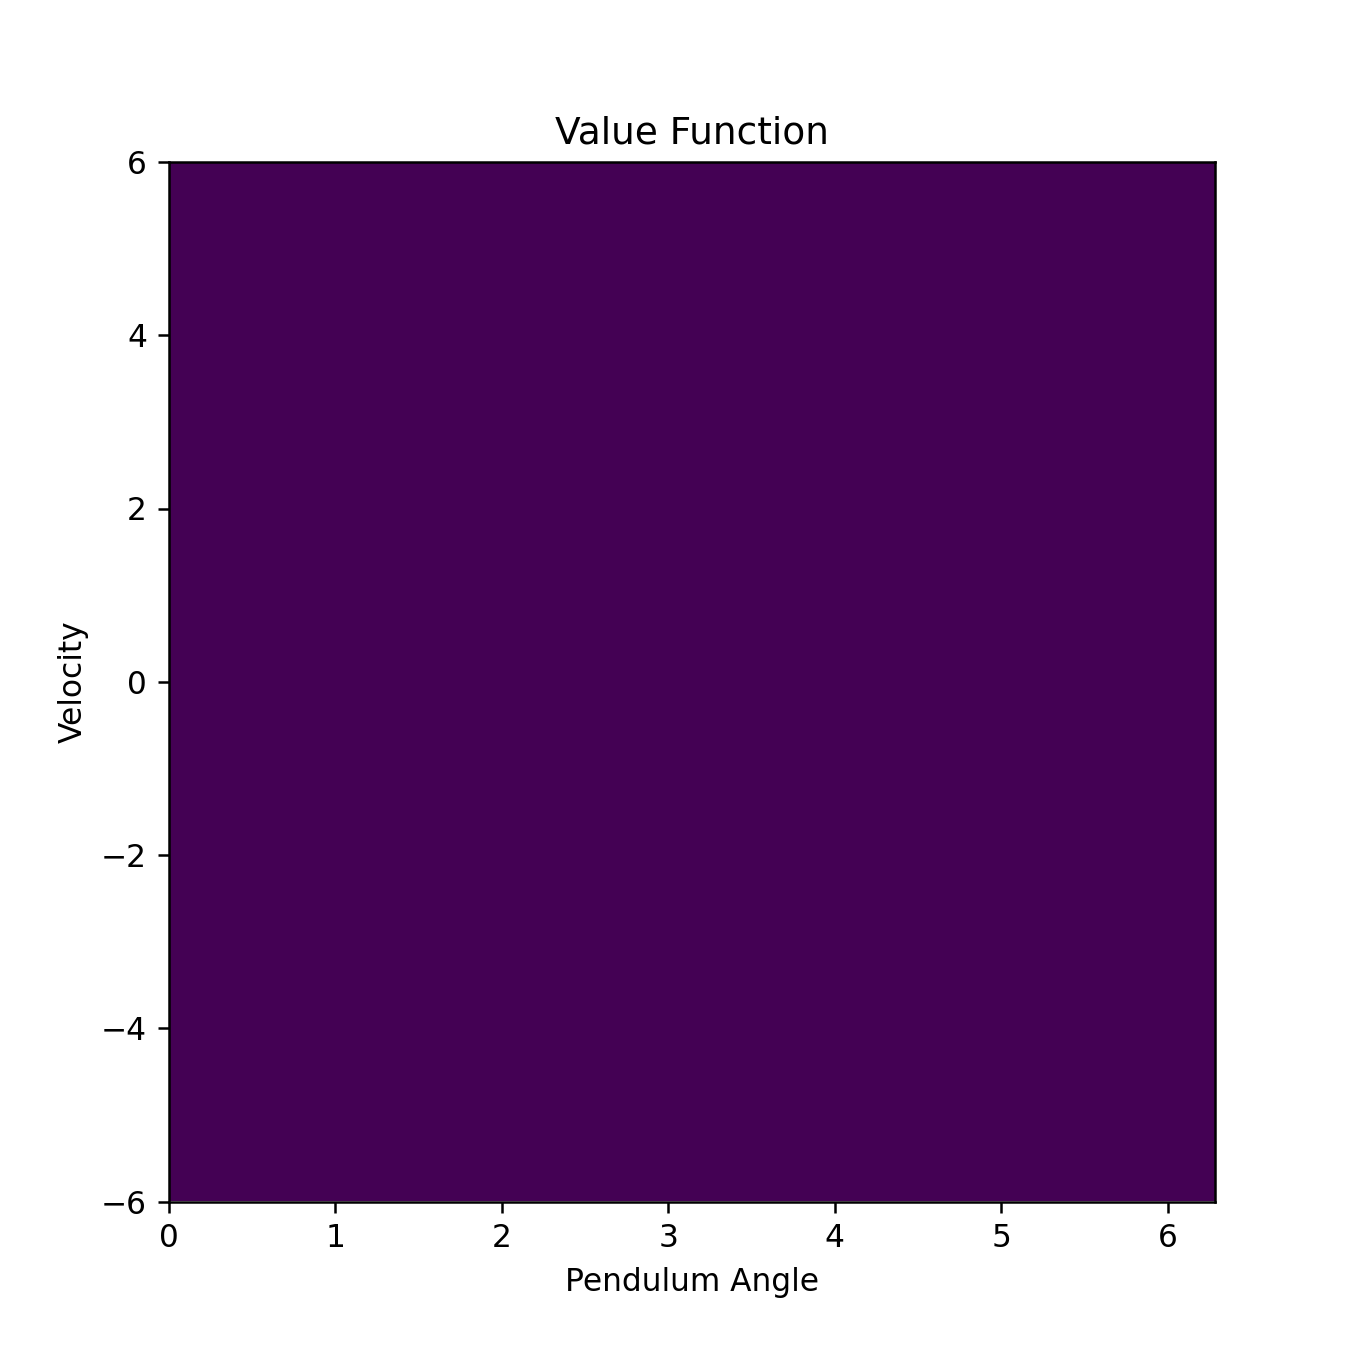

<IPython.core.display.Javascript object>


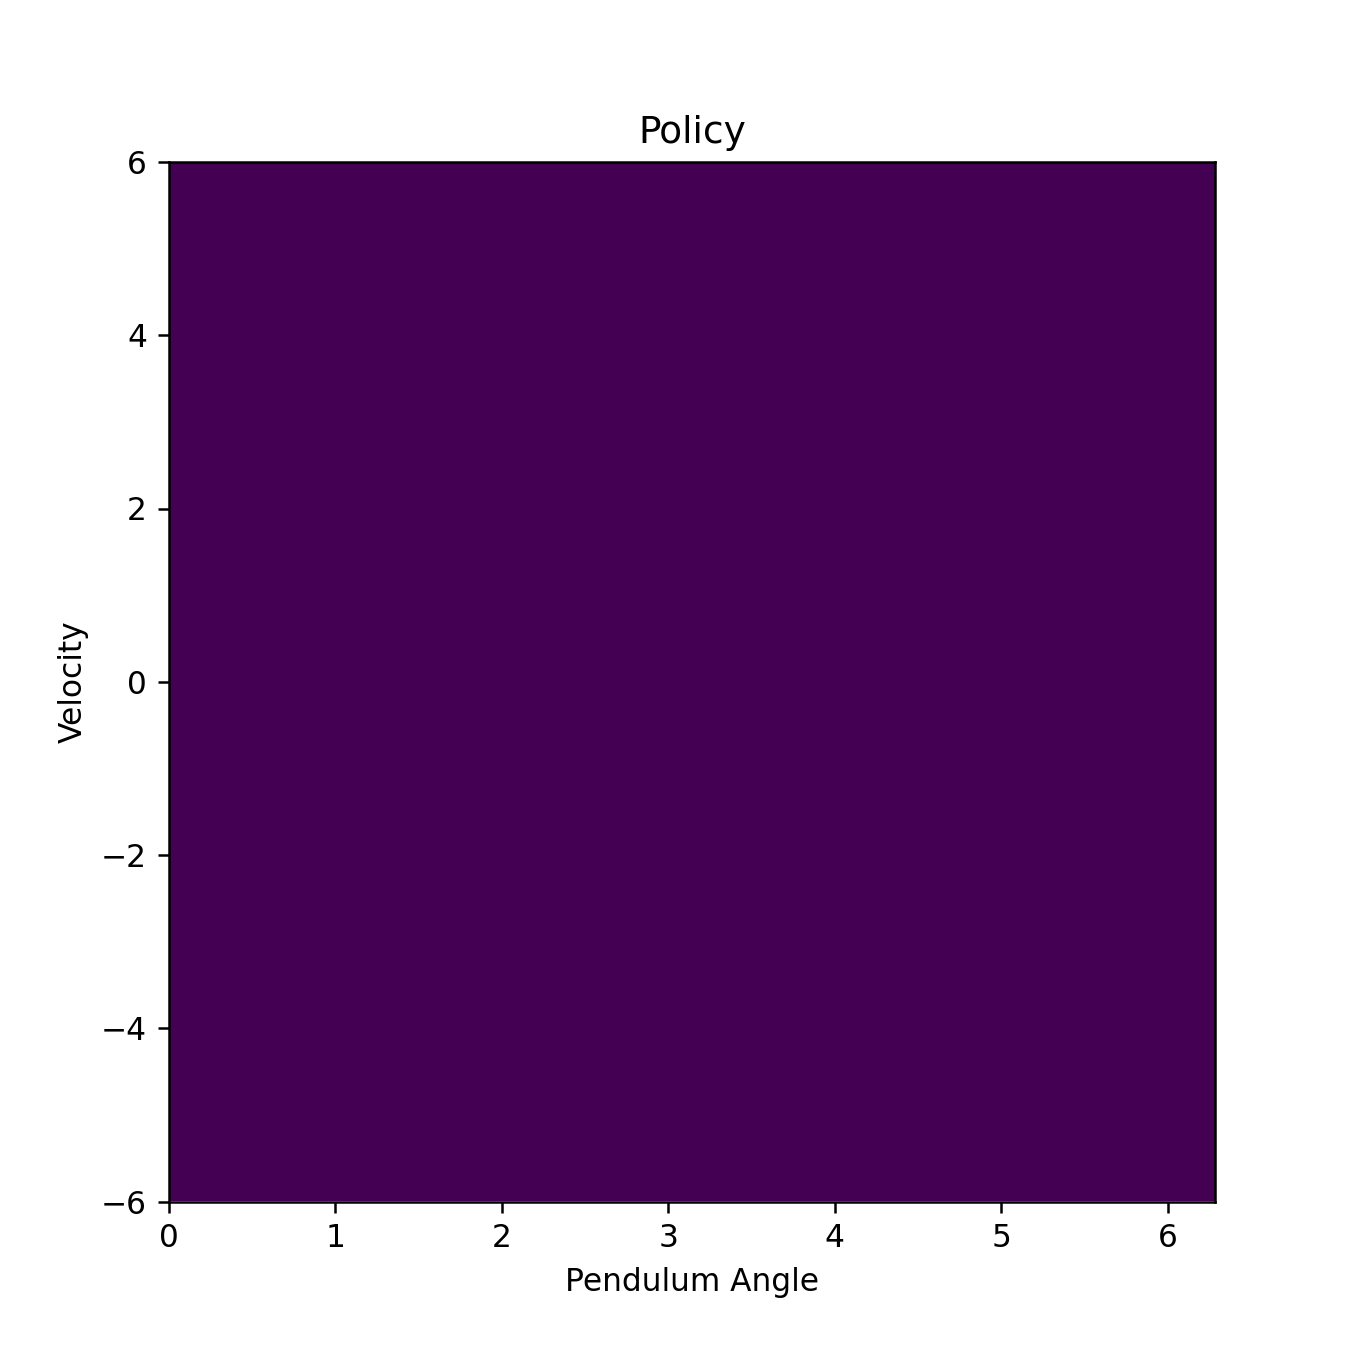

Text(0.5, 1.0, 'Policy')

In [8]:
# here is some code to plot results, assuming a policy and a value function are given
# this can be used to answer questions in both Part 1 and 2

value_function = np.zeros([50,50])
policy = np.zeros([50,50])

# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(value_function, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(policy, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')